In [16]:
%load_ext autoreload
%autoreload 2
from hypopredict.fusion.ml_preproc import MLPreprocessor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

mlp = MLPreprocessor()
path = '/Users/alexxela/code/hypopredict/data/processed/fusion_2/TRAIN_TIME_ml_prepped_cv_splits_20251218_131927.pkl'
loaded_dict = MLPreprocessor().load_prepped_splits(path)
splits_prepped = loaded_dict['splits_prepped']


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:

# carefully drop na values from each split
for SPLIT_INDEX in range(len(splits_prepped)):
    splits_prepped[SPLIT_INDEX][0]['target'] = splits_prepped[SPLIT_INDEX][1].values.copy()
    splits_prepped[SPLIT_INDEX][0].dropna(inplace=True)
    splits_prepped[SPLIT_INDEX] = (splits_prepped[SPLIT_INDEX][0].drop('target', axis=1),
                                   splits_prepped[SPLIT_INDEX][0]['target'].to_numpy())

# instantiate CV
from hypopredict.cv import CrossValidator
cv = CrossValidator(splits=splits_prepped)

resample = True
desired_pos_ratio = .4
reduction_factor = .7

splits_prepped_resampled = splits_prepped.copy()
if resample:
    cv.desired_pos_ratio = desired_pos_ratio
    cv.reduction_factor = reduction_factor

    for SPLIT_INDEX in range(len(splits_prepped)):
        splits_prepped_resampled[SPLIT_INDEX] = (
            cv._resample_split_recursive(
                splits_prepped_resampled[SPLIT_INDEX],
                desired_pos_ratio=cv.desired_pos_ratio,
                reduction_factor=cv.reduction_factor,
            )
        )

# stack X_trains from ALL splits
X_train = pd.concat(
    [splits_prepped_resampled[i][0] for i in range(len(splits_prepped_resampled))]
)
y_train = np.hstack(
    [splits_prepped_resampled[i][1] for i in range(len(splits_prepped_resampled))]
)

In [18]:
# initialize XGBoost model
from xgboost import XGBClassifier
xgb = XGBClassifier(
    n_estimators=1111,
    max_depth=2,
    reg_lambda=0.1,
    reg_alpha=0.05,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=17
)



from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", C=20.0, gamma="scale", probability=True))
])



# fit a KNN classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=55)



from sklearn.linear_model import LogisticRegression
#from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import StandardScaler
# fusion = Pipeline([
#     ("scaler", StandardScaler()),
#     ("logreg", LogisticRegression(max_iter=15000))
# ])

#fusion = LogisticRegression(max_iter=15000)
# TODO: make it lgbm for faster training

fusion = XGBClassifier(
    n_estimators=444,
    max_depth=2,
    learning_rate=0.05,
    eval_metric='logloss',
    random_state=17
)



xgb.fit(X_train, y_train)
svm.fit(X_train, y_train)
knn.fit(X_train, y_train)



path = '/Users/alexxela/code/hypopredict/data/processed/fusion_2/TEST_TIME_ml_prepped_cv_splits_20251218_134400.pkl'
loaded_dict_test = MLPreprocessor().load_prepped_splits(path)
split_prepped_test = loaded_dict_test['splits_prepped']

# persist the index
split_prepped_test[0][0].index = split_prepped_test[0][1].index
# stack X_trains from other splits
X_test = split_prepped_test[0][0].dropna(inplace=False)

y_probs_train_xgb = xgb.predict_proba(X_train)[:, 1]
y_probs_train_svm = svm.predict_proba(X_train)[:, 1]
y_probs_train_knn = knn.predict_proba(X_train)[:, 1]

y_probs_test_xgb = xgb.predict_proba(X_test)[:, 1]
y_probs_test_svm = svm.predict_proba(X_test)[:, 1]
y_probs_test_knn = knn.predict_proba(X_test)[:, 1]

X_train_fusion = pd.DataFrame({
    'xgb_prob': y_probs_train_xgb,
    'svm_prob': y_probs_train_svm,
    'knn_prob': y_probs_train_knn
})
#X_train_fusion = pd.concat([X_train_fusion, X_train.reset_index(drop=True)], axis=1)


X_test_fusion = pd.DataFrame({
    'xgb_prob': y_probs_test_xgb,
    'svm_prob': y_probs_test_svm,
    'knn_prob': y_probs_test_knn
})
#X_test_fusion = pd.concat([X_test_fusion, X_test.reset_index(drop=True)], axis=1)



fusion.fit(X_train_fusion, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


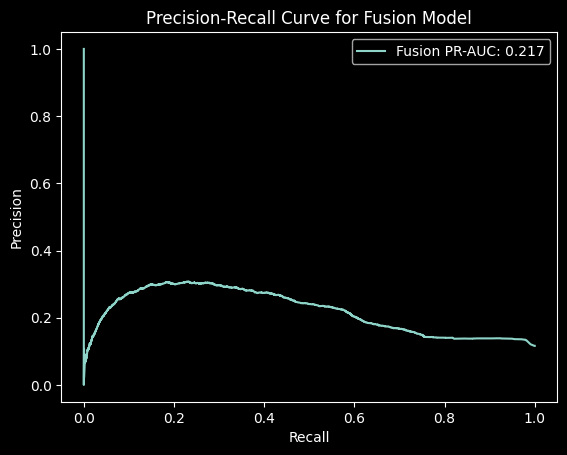

In [19]:

# PR-AUC curve
from sklearn.metrics import precision_recall_curve, auc
y_probs_test_fusion = fusion.predict_proba(X_test_fusion)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_probs_test_fusion)
pr_auc_fusion = auc(recall, precision)


plt.plot(recall, precision, label=f'Fusion PR-AUC: {pr_auc_fusion:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Fusion Model')
plt.legend()
plt.show()

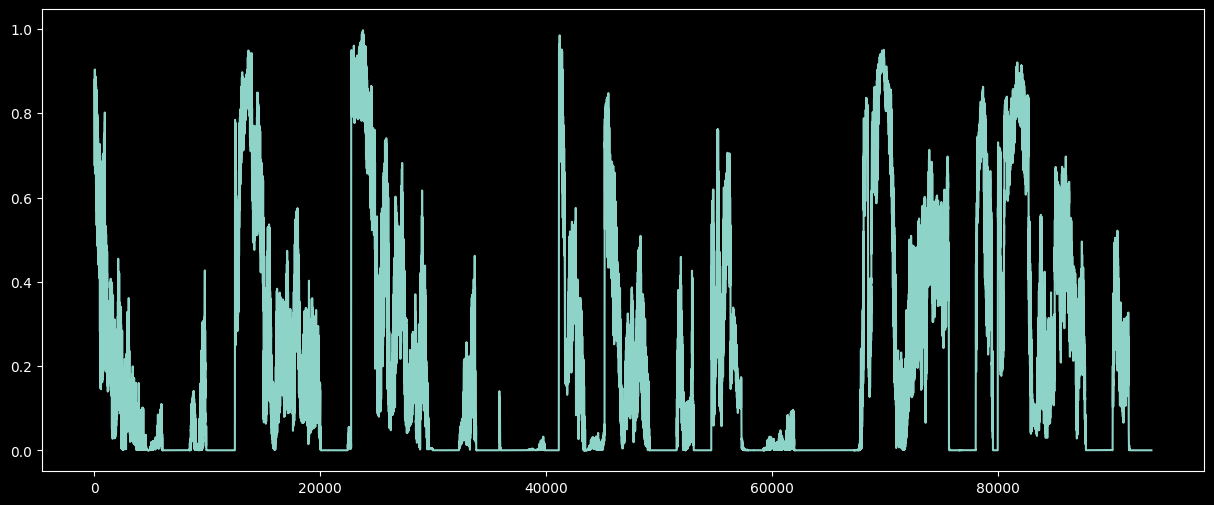

In [20]:
plt.figure(figsize=(15, 6))
plt.plot(pd.Series(y_probs_test_fusion).rolling(10).mean());

In [21]:
# save a dict of models into a pickle file
models_dict = {
    "xgb": xgb,
    "svm": svm,
    "knn": knn,
    "fusion": fusion
}
model_path = '/Users/alexxela/code/hypopredict/hypopredict/fusion/fusion 2.0 - finer chunking/'
metric = 267
model_name = f'fusion2_1_model_trained_dict_0_{metric}.pkl'
import pickle
with open(model_path + model_name, 'wb') as f:
    pickle.dump(models_dict, f)